In [1]:
import string 
import re
import itertools
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model 
from tensorflow.keras.layers import LSTM, Embedding, Dense, Bidirectional, Dropout, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [1]:
'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'

'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|]", "", text)
    text = " ".join(text.split())
    return text

In [6]:
with open('/content/movie_lines.txt', 'r', encoding='cp1252') as movie_lines:
    lines = movie_lines.read().split('\n')
    
movie_line_dict = {}
for line in lines:
    text = line.split(' +++$+++ ')[-1]
    index = line.split(' +++$+++ ')[0]
    clean_line = clean_text(text)
    tokinized_text = nltk.word_tokenize(clean_line)
    movie_line_dict[index] = tokinized_text
        
# movie_line_dict = {line.split(' +++$+++ ')[0]: nltk.word_tokenize(line.split(' +++$+++ ')[-1]) for line in lines}

with open('/content/movie_conversations.txt', 'r', encoding='cp1252') as movie_conversation:
    lines = movie_conversation.read().split('\n')
movie_conversation_list = [line.split(' +++$+++ ')[-1][1:-1].replace("'", '').split(', ') for line in lines]

In [7]:
words = list(itertools.chain(*list(movie_line_dict.values())))

In [8]:
values, count = np.unique(words, return_counts=True)
words_df = pd.DataFrame({'word' : values, 'count': count})
valid_words = words_df[words_df['count'] > 5]
vocab = {item: i+4 for i, item in enumerate(valid_words.word.values)}
vocab['<START>'] = 0
vocab['<FINISH>'] = 3
vocab['<PAD>'] = 2
vocab['<UNK>'] = 1
inv_vocab = {i: j for j, i in vocab.items()}


# vocab = np.append(np.array(word), ['<START>', '<UNK>', '<FINISH>'])
VOCAB_SIZE = len(vocab)


In [9]:
def char2indx(text: np.array, dec_tar=False, dec_inp=False):
    if dec_tar:
        return np.array([vocab[i] if i in vocab.keys() else 1 for i in text] + [3])
    if dec_inp:
        return np.array([0] + [vocab[i] if i in vocab.keys() else 1 for i in text])
    
    return np.array([vocab[i] if i in vocab.keys() else 1 for i in text])

def indx2char(mass: np.array):
    return ' '.join([inv_vocab[i] for i in mass])

In [10]:
# char2indx(movie_line_dict['L870'], dec_inp= True)


In [11]:
encoder_input, decoder_input, decoder_target  = [], [], []

for conv in movie_conversation_list:
    for line in range(len(conv)-1): 
        encoder_input.append(char2indx(movie_line_dict[conv[line]]))
        decoder_input.append(char2indx(movie_line_dict[conv[line+1]], dec_inp= True))
        decoder_target.append(char2indx(movie_line_dict[conv[line+1]], dec_tar= True))

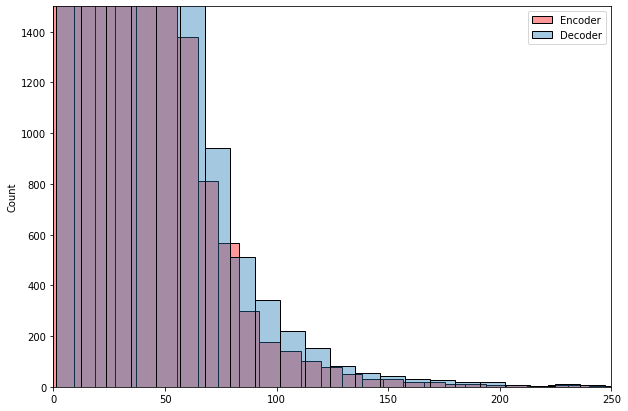

In [12]:
ax = plt.figure(figsize=(10,7))
plt.xlim(0, 250)
plt.ylim(0, 1500)

sns.histplot([len(i) for i in encoder_input], bins = 40, color='r', alpha = .4, label = 'Encoder',)
sns.histplot([len(i) for i in decoder_input], bins = 60, alpha =.4, label = 'Decoder')
plt.legend()
plt.show()

In [13]:
MAX_DEC_LEN_SEQ = 100
MAX_ENC_LEN_SEQ = 80

encoder_input_seqs = pad_sequences(
    encoder_input,
    value=vocab['<PAD>'],
    padding='post',
    truncating='post',
    maxlen=MAX_ENC_LEN_SEQ)

decoder_input_seqs = pad_sequences(
    decoder_input,
    value=vocab['<PAD>'],
    padding='post',
    truncating='post',
    maxlen=MAX_DEC_LEN_SEQ)

decoder_target_seqs = pad_sequences(
    decoder_target,
    value=vocab['<PAD>'],
    padding='post',
    truncating='post',
    maxlen=MAX_DEC_LEN_SEQ)


print('encoder_input_seqs shape: ', encoder_input_seqs.shape)
print('decoder_input_seqs shape: ', decoder_input_seqs.shape)
print('decoder_target_seqs shape: ', decoder_target_seqs.shape)

encoder_input_seqs shape:  (221616, 80)
decoder_input_seqs shape:  (221616, 100)
decoder_target_seqs shape:  (221616, 100)


In [14]:
print('encoder_input_seqs:\n', indx2char(encoder_input_seqs[10258]), end = '\n==============================\n')
print('decoder_input_seqs:\n', indx2char(decoder_input_seqs[10258]), end = '\n==============================\n')
print('decoder_target_seqs:\n', indx2char(decoder_target_seqs[10258]), end = '\n==============================\n')

encoder_input_seqs:
 no . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
decoder_input_seqs:
 <START> your mother came in about three in the afternoon . her neighbor drove her , on account of your father was on business in wichita . you were born a week early , but there were no complications . it was a perfect delivery . now , your father was sorry to miss it , but it was not the custom for the men to be in the room for deliveries then , so i can not see as it would have been much different had he been there . and that is the real story of how you
decoder_target_seqs:
 yo

In [15]:
data_enc, _, data_dec_tar, _, data_dec_inp, _ = train_test_split(
    *(encoder_input_seqs, decoder_target_seqs, decoder_input_seqs,
    ),
    train_size = 0.25)

print('data_enc shape: ', data_enc.shape)
print('data_dec_tar shape: ', data_dec_tar.shape)
print('data_dec_inp shape: ', data_dec_inp.shape)

data_enc shape:  (55404, 80)
data_dec_tar shape:  (55404, 100)
data_dec_inp shape:  (55404, 100)


In [16]:
enc_train, enc_val, dec_tar_train, dec_tar_val, dec_inp_train, dec_inp_val = train_test_split(
    *(data_enc, data_dec_tar,data_dec_inp),
    train_size = 0.9)

print('enx_train shape: ', enc_train.shape)
print('enx_val shape: ', enc_val.shape)
print('dec_tar_train shape: ', dec_tar_train.shape)
print('dec_tar_val shape: ', dec_tar_val.shape)
print('dec_inp_train shape: ', dec_inp_train.shape)
print('dec_inp_train shape: ', dec_inp_train.shape)


enx_train shape:  (49863, 80)
enx_val shape:  (5541, 80)
dec_tar_train shape:  (49863, 100)
dec_tar_val shape:  (5541, 100)
dec_inp_train shape:  (49863, 100)
dec_inp_train shape:  (49863, 100)


In [17]:
EMB_SIZE = 256
H_SIZE = 512


class Encoder(Model):
    def __init__(self):
        super().__init__()
        self.emb = Embedding(VOCAB_SIZE, EMB_SIZE)
        self.lstm = LSTM(H_SIZE, return_sequences = False, return_state = True)

    def call(self, inp):
        out = self.emb(inp)
        _, h, c = self.lstm(out)
        return (h, c)
    
class Decoder(Model):
    def __init__(self):
        super().__init__()
        self.emb = Embedding(VOCAB_SIZE, EMB_SIZE)
        self.lstm = LSTM(H_SIZE, return_sequences = True, return_state = True)
        self.fc = Dense(VOCAB_SIZE, activation = 'softmax')
        
    def call(self, inp, init_state):
        out = self.emb(inp)
        out, h, c = self.lstm(out, initial_state = init_state)
        out = self.fc(out)
        return out, (h, c)
    

encoder = Encoder()
decoder = Decoder()
        
        
encoder_inputs = Input(shape = (None,) )
decoder_inputs = Input(shape = (None,) )

enc_state = encoder(encoder_inputs)
decoder_outputs, _ = decoder(decoder_inputs, enc_state)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
BATCH_SIZE = 256
EPOCHs = 10

callback = ModelCheckpoint(
    '/content/drive/MyDrive/ChatBot',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
    )

loss = SparseCategoricalCrossentropy()
model.compile(loss = loss, optimizer = 'adam', metrics = ['accuracy'])

model.fit([enc_train, dec_inp_train],
          dec_tar_train,
          epochs = EPOCHs, 
          validation_data=([[enc_val, dec_inp_val]], dec_tar_val),
          batch_size = BATCH_SIZE, 
          callbacks = [callback])

Epoch 1/10
195/195 [==============================] - 7650s 39s/step - loss: 1.3542 - accuracy: 0.8485 - val_loss: 0.8097 - val_accuracy: 0.8746
Epoch 2/10
 32/195 [===>..........................] - ETA: 1:42:07 - loss: 0.8049 - accuracy: 0.8756